# Monte Carlo Simulation of Geometric Brownian Motion: AAPL Forecasting and European Call Pricing

In this notebook we simulate future price paths for **Apple Inc. (AAPL)** using a **Geometric Brownian Motion (GBM)** model calibrated from historical **daily log returns**. The simulated terminal price distribution over a **6-month horizon** is then used to price a **European call option** via Monte Carlo.

Note: in the **forecast / comparison with the realized path** we calibrate the model using **historical returns** (physical/real-world measure). For **option pricing**, we switch to the **risk-neutral** drift (the risk-free rate $r$).


A key goal of the analysis is to study the **convergence of the Monte Carlo estimator**: we compute the call price for increasing numbers of simulations $N$ and track how the estimate stabilizes as $N$ grows, together with its **standard error** and confidence bands. This provides an empirical illustration of the typical Monte Carlo behavior, where the estimation error decreases approximately at the rate $O(N^{-1/2})$.


## Environment setup

This cell imports the Python libraries used throughout the notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

## Configuration

Set the main parameters

In [ ]:
# --- parameters ---
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
HORIZON_MONTHS = 6               # Forecast horizon in months
TRADING_DAYS_PER_YEAR = 252      # Trading days convention


N_SIMULATIONS = 10000            # Number of Monte Carlo simulations (paths)
SEED = 42                        # Random seed


# Montecarlo simulation finish at the end of time horizon
MC_START_DATE = END_DATE
MC_END_DATE = (pd.to_datetime(MC_START_DATE) +
                pd.DateOffset(months=HORIZON_MONTHS)).strftime("%Y-%m-%d")

RISK_FREE_RATE = 0.02            # Risk-free rate

## Download of the data


In [ ]:
# Download of the historical AAPL time serie

df = yf.download("AAPL", start= START_DATE, end= MC_END_DATE, auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02,72.468292,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,71.763725,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.335564,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,71.995346,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.153488,75.797501,76.110001,74.290001,74.290001,132079200
...,...,...,...,...,...,...
2025-06-24,199.879181,200.300003,203.440002,200.199997,202.589996,54064000
2025-06-25,201.136520,201.559998,203.669998,200.619995,201.449997,39525700


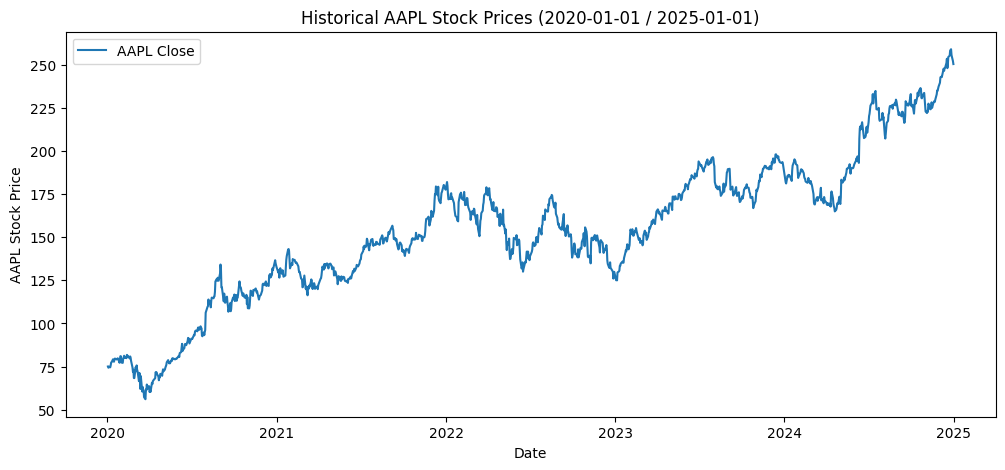

In [ ]:
display(df)

# Fix MultiIndex columns returned by yfinance (field, ticker) -> (field)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Use Close prices (spot-like). We keep the full series for the realized path,
# and we calibrate the model only on the historical window up to MC_START_DATE.
prices_all = df["Close"].dropna()

calibration_prices = prices_all.loc[prices_all.index < pd.to_datetime(MC_START_DATE)]
prices = calibration_prices


# ----- Data Visualization ----
plt.figure(figsize=(12, 5))
plt.plot(prices, label='AAPL Close')
plt.title(f'Historical AAPL Stock Prices ({START_DATE} / {END_DATE})')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()


## Log Returns, Mean and Volatility Estimation

We work with **daily log returns** defined as:

$$
r_t = \ln\left(\frac{S_t}{S_{t-1}}\right)
$$

where $S_t$ is the adjusted close price at day $t$.  
From the log-return series $\{r_t\}$ we estimate the **sample mean** $\hat{\mu}$ and the **sample volatility** $\hat{\sigma}$ (standard deviation), which will be used to calibrate the GBM model.


### Annualization

To express them on an **annual** basis (using the standard convention of $252$ trading days per year), we apply:

$$
\mu_{\text{ann}} = 252 \cdot \mu_{\text{daily}}
$$

$$
\sigma_{\text{ann}} = \sqrt{252} \cdot \sigma_{\text{daily}}
$$

These annualized parameters are useful for reporting and for setting up the GBM dynamics over a horizon measured in years.


Number of observations: 1257
Mean Daily log-returns 0.000958
Standard Deviation of Daily log-returns 0.019942

Annualized mean of log-returns (mu - 0.5*sigma^2): 0.241472
Annualized volatility (sigma):                   0.316563
Implied annualized drift (mu):                   0.291578


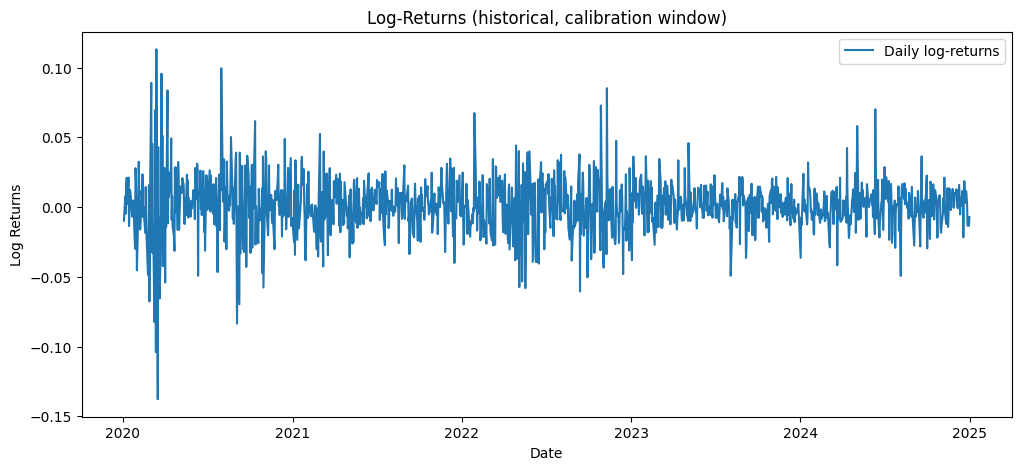

In [ ]:
log_returns = np.log(prices / prices.shift(1)).dropna()

mean_log = log_returns.mean()
volatility = log_returns.std()

# Annualization
mean_annualized = mean_log * TRADING_DAYS_PER_YEAR
volatility_annualized = volatility * np.sqrt(TRADING_DAYS_PER_YEAR)

# IMPORTANT: for a GBM written as dS = mu*S*dt + sigma*S*dW,
# the mean of log-returns estimates (mu - 0.5*sigma^2).
# Therefore we recover mu by adding back 0.5*sigma^2 (annualized units).
mu_annualized = mean_annualized + 0.5 * volatility_annualized**2


print(f"Number of observations: {len(log_returns)}")
print(f"Mean Daily log-returns {mean_log:.6f}")
print(f"Standard Deviation of Daily log-returns {volatility:.6f}\n")

print(f"Annualized mean of log-returns (mu - 0.5*sigma^2): {mean_annualized:.6f}")
print(f"Annualized volatility (sigma):                   {volatility_annualized:.6f}")
print(f"Implied annualized drift (mu):                   {mu_annualized:.6f}")



# Visualization of log returns
plt.figure(figsize=(12,5))
plt.plot(log_returns, label='Daily log-returns')
plt.title('Log-Returns (historical, calibration window)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()


## Geometric Brownian Motion (GBM)

We model the stock price $S_t$ with a **Geometric Brownian Motion**.  
Under GBM, the price dynamics are given by:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where $\mu$ is the drift (expected return), $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion.

In discrete time, using a time step $dt$ (in years), the GBM solution can be simulated as:

$$
S_{t+dt} = S_t \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)dt + \sigma\sqrt{dt}\,Z\right]
$$

with $Z \sim \mathcal{N}(0,1)$.


## Time Step $dt$ and Horizon $T$

To simulate a GBM in discrete time, we need a time step $dt$ expressed in **years**.  
Since we work with **daily** data, we use the standard convention of **252 trading days per year**, so one step corresponds to one trading day:

$$
dt = \frac{1}{252}
$$

If the Monte Carlo window contains `MC_steps` trading steps, the total simulation horizon (in years) is:

$$
T = \text{MC\_steps} \cdot dt
$$

We use $dt$ inside each GBM update, while $T$ is used to summarize the total maturity (e.g., for discounting and option pricing). The random term scales with $\sqrt{dt}$, which reflects the fact that volatility grows approximately like $\sqrt{t}$.


In [ ]:
# trading days in the Monte Carlo window (use real trading days from the dataset)
real_path = prices_all.loc[pd.to_datetime(MC_START_DATE):pd.to_datetime(MC_END_DATE)]

MC_dates = real_path.index
MC_steps = len(MC_dates) - 1

dt = 1.0 / TRADING_DAYS_PER_YEAR
T = MC_steps * dt

print(f"Monte Carlo start date: {MC_START_DATE}")
print(f"Monte Carlo end date:   {MC_END_DATE}")
print(f"Number of steps (trading days): {MC_steps}")
print(f"dt (in years): {dt:.6f}")
print(f"T  (in years): {T:.6f}")


Monte Carlo start date: 2025-01-01
Monte Carlo end date:   2025-07-01
Number of steps (trading days): 121
dt (in years): 0.003968
T  (in years): 0.480159


MC_paths_df shape: (10000, 122)


Date,2025-01-02,2025-01-03,2025-01-06,2025-01-07,2025-01-08,2025-01-10,2025-01-13,2025-01-14,2025-01-15,2025-01-16,...,2025-06-16,2025-06-17,2025-06-18,2025-06-20,2025-06-23,2025-06-24,2025-06-25,2025-06-26,2025-06-27,2025-06-30
0,243.850006,246.513512,246.070435,249.508252,257.449059,256.495392,255.545341,263.973868,268.301733,266.056413,...,210.216268,210.670681,221.489544,220.853066,222.398135,222.457304,217.541165,222.769152,226.351481,230.170810
1,243.850006,239.697302,246.733567,240.161626,243.221666,254.324918,249.589606,247.023465,247.752128,245.512257,...,316.244732,312.461308,326.422500,330.892034,318.099991,319.591044,315.703451,321.423780,316.687197,316.266344
2,243.850006,246.554185,251.088271,245.384641,243.986934,241.918701,239.016243,247.818277,250.067263,244.091732,...,293.504243,293.674234,288.137352,288.307126,286.927115,289.056444,284.599773,287.838256,297.056456,296.697048
3,243.850006,246.046934,249.695733,247.943364,249.292607,249.594268,250.320654,246.727843,247.085115,249.790353,...,274.762944,273.663910,277.093901,279.086422,297.043186,304.040793,303.556945,298.112947,288.990997,290.444106
4,243.850006,240.429927,233.930692,231.155213,226.439958,234.412494,238.798928,238.989860,246.384127,247.001122,...,212.473250,211.535446,207.645579,206.011292,207.766153,211.128504,207.480164,211.311912,217.310480,219.319571


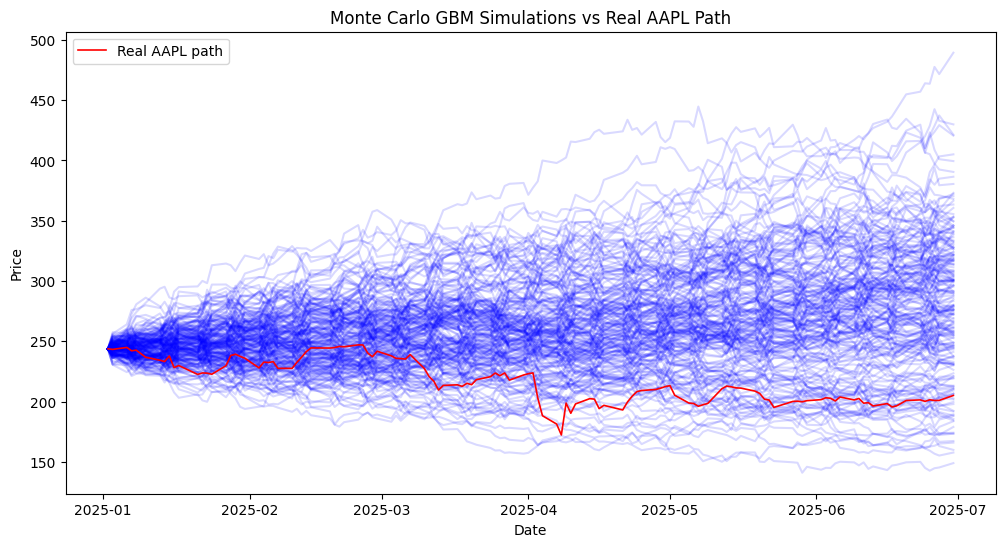

In [ ]:
# --- Monte Carlo simulation (GBM) ---
np.random.seed(SEED)

# Starting price at the beginning of the Monte Carlo window
S0 = real_path.iloc[0]

mu = mu_annualized
sigma = volatility_annualized

MC_paths = np.zeros((N_SIMULATIONS, MC_steps + 1))
MC_paths[:, 0] = S0

for i in range(N_SIMULATIONS):
  # generate all shocks for this simulation (one per day)
  Z = np.random.normal(0, 1, size=MC_steps)

  for t in range(1, MC_steps + 1):
    # log-return increment under GBM
    increment = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t - 1]

    # update price
    MC_paths[i, t] = MC_paths[i, t - 1] * np.exp(increment)

MC_paths_df = pd.DataFrame(MC_paths, columns=MC_dates)

print(f"MC_paths_df shape: {MC_paths_df.shape}")
display(MC_paths_df.head())

# --- plot Monte Carlo paths + real path ---
N_PLOT = 200  # number of simulated paths to plot

plt.figure(figsize=(12, 6))

# plot simulated paths
for i in range(min(N_PLOT, N_SIMULATIONS)):
  plt.plot(MC_dates, MC_paths_df.iloc[i, :], color="blue", alpha=0.15)

# plot real path in red
plt.plot(MC_dates, real_path.values, color="red", linewidth=1.2, label="Real AAPL path")

plt.title("Monte Carlo GBM Simulations vs Real AAPL Path")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## VaR (95%) and Real Path Percentile

Using the simulated terminal prices, we compute the **95% Value at Risk (VaR)** over the horizon, i.e. the loss threshold that is exceeded only in the worst **5%** of Monte Carlo scenarios.  
We also compute the **percentile of the realized outcome** within the simulated distribution to see how “extreme” the real path was compared to the model.



In [ ]:
# --- VaR 95% and real path percentile ---
ALPHA = 0.95

# Terminal prices from Monte Carlo
S_T_mc = MC_paths_df.iloc[:, -1]

# Real terminal price
S_T_real = real_path.iloc[-1]

# Returns over the horizon
R_mc = (S_T_mc / S0) - 1.0
R_real = (S_T_real / S0) - 1.0

# VaR at 95% computed on losses (non-negative by definition)
L_mc = -R_mc
VaR_95_return = np.quantile(L_mc, ALPHA)
VaR_95_price = VaR_95_return * S0

# Percentile of the real outcome vs MC distribution (in terms of returns)
real_percentile = (R_mc < R_real).mean() * 100

print(f"S0: {S0:.4f}")
print(f"Real terminal price: {S_T_real:.4f}")
print(f"Real return over horizon: {R_real*100:.3f}%\n")

print(f"VaR {int(ALPHA*100)}% (loss fraction): {VaR_95_return*100:.3f}%")
print(f"VaR {int(ALPHA*100)}% (price loss):    {VaR_95_price:.4f}\n")

print(f"Real outcome percentile vs MC (returns): {real_percentile:.2f}%")


S0: 243.8500
Real terminal price: 205.1700
Real return over horizon: -15.862%

VaR 95% (loss fraction): 22.647%
VaR 95% (price loss):    55.2239

Real outcome percentile vs MC (returns): 9.69%


# European Call Option Pricing (Monte Carlo)

We price a **European call option** with payoff:
$$
\text{Payoff} = \max(S_T - K, 0)
$$

Instead of simulating the full path, we simulate the terminal price directly using the closed-form **GBM** solution:
$$
S_T = S_0 \exp\left(\left(r-\tfrac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}\,Z\right),
\qquad Z \sim \mathcal{N}(0,1)
$$

Under the **risk-neutral measure**, the option price is the discounted expected payoff:
$$
C_0 = e^{-rT}\,\mathbb{E}\left[\max(S_T - K, 0)\right]
$$

To be consistent with Black–Scholes / GBM pricing, we simulate $S_T$ using the **risk-free rate** $r$ as drift (risk-neutral drift), while keeping the volatility $\sigma$ estimated from historical data.

With $N$ Monte Carlo simulations, the estimator becomes:
$$
\hat{C}_0(N) = e^{-rT}\,\frac{1}{N}\sum_{i=1}^N \max\left(S_T^{(i)}-K,0\right)
$$

## Standard error and confidence interval

For each $N$ in a grid (increasing sample sizes), we compute the estimate $\hat{C}_0(N)$ and the Monte Carlo **standard error**:
$$
SE(N) = e^{-rT}\,\frac{s}{\sqrt{N}}
$$
where $s$ is the sample standard deviation of the payoff.

Using the Central Limit Theorem, we also report an approximate 95% confidence interval:
$$
\hat{C}_0(N) \pm 1.96\,SE(N)
$$

By increasing $N$, the estimate converges and the confidence interval shrinks roughly at a $1/\sqrt{N}$ rate.

#

In [ ]:
# --- option parameters ---
K = S0                 # ATM strike
r = RISK_FREE_RATE     # risk-free rate
sigma = volatility_annualized

print(f"S0: {S0:.4f}")
print(f"K:  {K:.4f}")
print(f"r:  {r:.4f}")
print(f"sigma (annualized): {sigma:.4f}")
print(f"T (years): {T:.6f}")


S0: 243.8500
K:  243.8500
r:  0.0200
sigma (annualized): 0.3166
T (years): 0.480159


In [ ]:
# --- Monte Carlo pricing + convergence ---
np.random.seed(SEED)

N_GRID = [100, 300, 1000, 3000, 10000, 30000, 100000]
N_MAX = max(N_GRID)

# Simulate terminal prices under risk-neutral GBM
Z = np.random.normal(0, 1, size=N_MAX)
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

discount = np.exp(-r * T)

mc_prices = []
mc_se = []

for N in N_GRID:
    payoff = np.maximum(S_T[:N] - K, 0.0)
    price_N = discount * payoff.mean()
    se_N = discount * payoff.std(ddof=1) / np.sqrt(N)

    mc_prices.append(price_N)
    mc_se.append(se_N)

    print(f"N={N:>6d}  Call price={price_N:.6f}  SE={se_N:.6f}  95% CI=[{price_N-1.96*se_N:.6f}, {price_N+1.96*se_N:.6f}]")


N=   100  Call price=16.626639  SE=2.797958  95% CI=[11.142641, 22.110637]
N=   300  Call price=21.645512  SE=2.197144  95% CI=[17.339109, 25.951915]
N=  1000  Call price=22.437011  SE=1.175290  95% CI=[20.133442, 24.740579]
N=  3000  Call price=22.975095  SE=0.678316  95% CI=[21.645596, 24.304594]
N= 10000  Call price=22.388012  SE=0.365378  95% CI=[21.671870, 23.104153]
N= 30000  Call price=22.329329  SE=0.209632  95% CI=[21.918450, 22.740208]
N=100000  Call price=22.436284  SE=0.115062  95% CI=[22.210762, 22.661806]


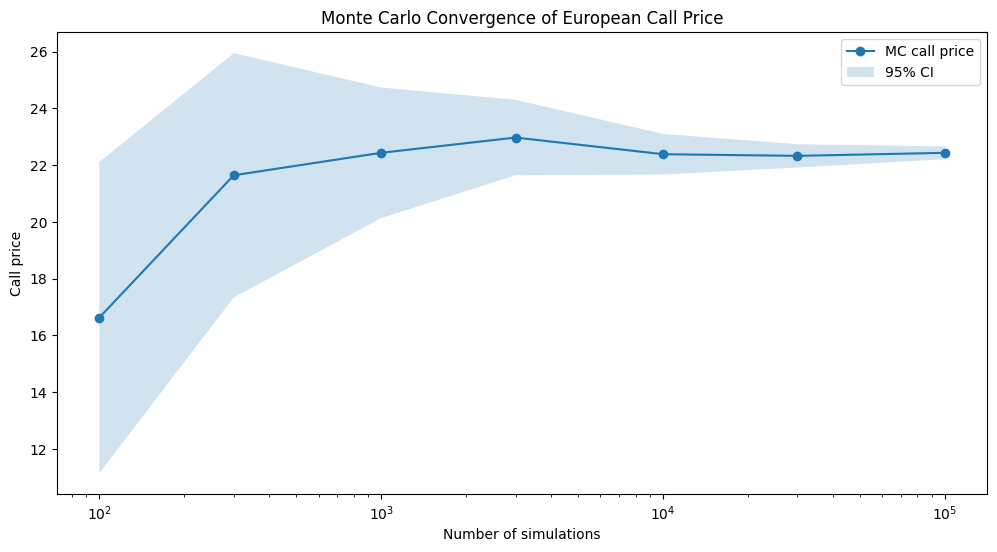

In [ ]:
# --- plot convergence ---
mc_prices = np.array(mc_prices)
mc_se = np.array(mc_se)

plt.figure(figsize=(12, 6))
plt.plot(N_GRID, mc_prices, marker="o", label="MC call price")
plt.fill_between(N_GRID, mc_prices - 1.96*mc_se, mc_prices + 1.96*mc_se, alpha=0.2, label="95% CI")
plt.xscale("log")
plt.title("Monte Carlo Convergence of European Call Price")
plt.xlabel("Number of simulations")
plt.ylabel("Call price")
plt.legend()
plt.show()
